##### 1. Join the data from Part 1 with the data from Part 2 to create a new dataframe.
##### 2. Use data visualization to explore the data.
##### 3. Create your own SQLite database and store the data you've collected on the POIs. Put some thought into the structure of your database. We've used and created sqlite3 databases before in the activity SQL in Python. Validate your data.

In [1]:
import pandas as pd
import os # use this to access your environment variables
import requests # this will be used to call the APIs
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from scipy import stats
import json #json parsing libraries
import datetime

In [30]:
import matplotlib.pyplot as plt #both these offer visualization tools
import seaborn as sns

In [2]:
#Now that we have the Four Square data, obtained with the fs_append function, seen in the previous section
#we can join it to the .json files we have created. This process will be repeated for each dataset.

In [3]:
data1 = pd.read_json(r'unprocessed/Chi_9am_mon(raw).json')
df = pd.DataFrame(data1)
print(df.info())
df.head(1)

<class 'pandas.core.frame.DataFrame'>
Index: 1663 entries, 0 to 1662
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   comp_id     1663 non-null   object        
 1   name        1663 non-null   object        
 2   latitude    1663 non-null   float64       
 3   longitude   1663 non-null   float64       
 4   slots       1663 non-null   int64         
 5   free_bikes  1663 non-null   int64         
 6   renting     1663 non-null   int64         
 7   timestamp   1663 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 116.9+ KB
None


,comp_id,name,latitude,longitude,slots,free_bikes,renting,timestamp
0,divvy,Lake Park Ave & 56th St,41.793242,-87.587782,19,13,1,2023-11-20 15:01:15.831


In [6]:
df_fs = pd.read_json('four_square_9am_mon.json')

In [8]:
#now we join the data from Four Square obtained by calling fs_append on the response from the 
df['distance'] = df_fs['distance']
df['near_station'] = df_fs['near_station']
df['num_stations_1mi'] = df_fs['num_stations_1mi']
df['num_stations_2mi'] = df_fs['num_stations_2mi']
df['all_stations'] = df_fs['all_stations'] #this column could be dropped, but I wanted to keep it in case the total was needed for some calculation later

In [9]:
# previously, only two transit categories were used, looking at divvy stations within 150ft of a CTA station, and then all others.
# this did not produce adequate results, so additional categories were added
#I hope this will give the data greater explanitory power
df['transit_cat'] = 0 ### this will track stations which are beside (or nearly so) CTA stations
df.loc[(df['distance']<=50, 'transit_cat')] = 0 #w/in 50m (150ft) of an L station
df.loc[(df['distance'].between(51, 182), 'transit_cat')] = 1 #between 150ft and 600 feet of an L station
df.loc[(df['distance'].between(183, 365), 'transit_cat')] = 2 #between 601 and 1200 feet
df.loc[(df['distance']>365, 'transit_cat')] = 3 #greater than 1200 feet from an L station

In [10]:
#the above processes are repeated for the other snapshots taken during rushhour,
#creating separate dataframes which will be processed to show the useage over time
#this will also be archived as .json to preseve data

In [11]:
#checking to be sure the rows and datatypes match, which will indicate all processes have been completed correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1663 entries, 0 to 1662
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   comp_id           1663 non-null   object        
 1   name              1663 non-null   object        
 2   latitude          1663 non-null   float64       
 3   longitude         1663 non-null   float64       
 4   slots             1663 non-null   int64         
 5   free_bikes        1663 non-null   int64         
 6   renting           1663 non-null   int64         
 7   timestamp         1663 non-null   datetime64[ns]
 8   distance          1663 non-null   int64         
 9   near_station      1663 non-null   object        
 10  num_stations_1mi  1663 non-null   int64         
 11  num_stations_2mi  1663 non-null   int64         
 12  all_stations      1663 non-null   int64         
 13  transit_cat       1663 non-null   int64         
dtypes: datetime64[ns](1), float64

In [12]:
print(df.describe())
print(df.head())

          latitude    longitude        slots   free_bikes      renting  \
count  1663.000000  1663.000000  1663.000000  1663.000000  1663.000000   
mean     41.850887   -87.678532     9.049910     3.600120     0.997595   
min      41.648501   -87.843960     1.000000     0.000000     0.000000   
25%      41.766388   -87.720899     2.000000     0.000000     1.000000   
50%      41.867226   -87.677180     9.000000     1.000000     1.000000   
75%      41.931753   -87.634429    15.000000     6.000000     1.000000   
max      42.064854   -87.528232    55.000000    34.000000     1.000000   
std       0.097214     0.063382     8.543893     4.783966     0.048999   

                           timestamp     distance  num_stations_1mi  \
count                           1663  1663.000000       1663.000000   
mean   2023-11-20 15:01:14.925148416  1577.116657          4.146723   
min       2023-11-20 15:01:13.130000     3.000000          0.000000   
25%    2023-11-20 15:01:14.154500096   709.000000

In [13]:
df.rename(columns={'free_bikes': 'avail_bikes_9am'}, inplace=True) #creating the columns we'll need to examine data across time periods
df['change_8_to_830'] = 0
df['change_830_to_9'] = 0
df['change_8_to_9'] = 0

In [14]:
#now we will add the usage data from our other snapshots
data1 = pd.read_json(r'unprocessed/Chi_8am_mon(raw).json')
data2 = pd.read_json(r'unprocessed/Chi_830am_mon(raw).json')

In [20]:
data1.head()

,comp_id,name,latitude,longitude,slots,free_bikes,renting,timestamp
0,divvy,Lake Park Ave & 56th St,41.793242,-87.587782,19,15,1,2023-11-20 14:05:46.840
1,divvy,Ada St & Washington Blvd,41.882830,-87.661206,15,12,1,2023-11-20 14:05:46.840
2,divvy,Ashland Ave & Grace St,41.950687,-87.668700,15,14,1,2023-11-20 14:05:46.840
3,divvy,Clark St & Wrightwood Ave,41.929546,-87.643118,15,11,1,2023-11-20 14:05:46.840
4,divvy,Adler Planetarium,41.866095,-87.607267,39,12,1,2023-11-20 14:05:46.840


In [21]:
data2.head()

,comp_id,name,latitude,longitude,slots,free_bikes,renting,timestamp
0,divvy,Lake Park Ave & 56th St,41.793242,-87.587782,19,14,1,2023-11-20 14:25:43.977
1,divvy,Ada St & Washington Blvd,41.882830,-87.661206,15,11,1,2023-11-20 14:25:43.977
2,divvy,Ashland Ave & Grace St,41.950687,-87.668700,15,14,1,2023-11-20 14:25:43.977
3,divvy,Clark St & Wrightwood Ave,41.929546,-87.643118,15,9,1,2023-11-20 14:25:43.977
4,divvy,Adler Planetarium,41.866095,-87.607267,39,12,1,2023-11-20 14:25:43.977


In [22]:
change_8_to_830 = data2['free_bikes'] - data1['free_bikes'] #the difference in bikes avail. between 8am and 830
change_830_to_9 = df['avail_bikes_9am'] - data2['free_bikes'] #the difference in bikes avail. between 830am and 9
change_8_to_9 = df['avail_bikes_9am'] - data1['free_bikes'] #the difference in bikes avail. between 8am and 9
df['change_8_to_830'] = change_8_to_830
df['change_830_to_9'] = change_830_to_9
df['change_8_to_9'] = change_8_to_9

In [23]:
df.head() #examining the data to make sure everything looks good

,comp_id,name,latitude,longitude,slots,avail_bikes_9am,renting,timestamp,distance,near_station,num_stations_1mi,num_stations_2mi,all_stations,transit_cat,change_8_to_830,change_830_to_9,change_8_to_9
0,divvy,Lake Park Ave & 56th St,41.793242,-87.587782,19,13,1,2023-11-20 15:01:15.831,653,"5311 S Lake Park Ave (at 53rd St), Chicago, IL...",8,2,10,3,-1,-1,-2
1,divvy,Ada St & Washington Blvd,41.882830,-87.661206,15,10,1,2023-11-20 15:01:13.757,384,"1200 W Randolph St, Chicago, IL 60607",9,1,10,3,-1,-1,-2
2,divvy,Ashland Ave & Grace St,41.950687,-87.668700,15,13,1,2023-11-20 15:01:16.001,432,1612 W Irving Park Rd (btwn Ashland Ave. & Pau...,10,0,10,3,0,-1,-1
3,divvy,Clark St & Wrightwood Ave,41.929546,-87.643118,15,7,1,2023-11-20 15:01:13.758,500,"2548 N Halsted St (at Wrightwood Ave), Chicago...",10,0,10,3,-2,-2,-4
4,divvy,Adler Planetarium,41.866095,-87.607267,39,12,1,2023-11-20 15:01:14.360,1421,"1416 S Michigan Ave, Chicago, IL 60605",5,5,10,3,0,0,0


In [24]:
df.describe()

,latitude,longitude,slots,avail_bikes_9am,renting,timestamp,distance,num_stations_1mi,num_stations_2mi,all_stations,transit_cat,change_8_to_830,change_830_to_9,change_8_to_9
count,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000
mean,41.850887,-87.678532,9.049910,3.600120,0.997595,2023-11-20 15:01:14.925148416,1577.116657,4.146723,5.364402,9.511124,2.821407,0.009020,-0.003007,0.006013
min,41.648501,-87.843960,1.000000,0.000000,0.000000,2023-11-20 15:01:13.130000,3.000000,0.000000,0.000000,2.000000,0.000000,-4.000000,-10.000000,-10.000000
25%,41.766388,-87.720899,2.000000,0.000000,1.000000,2023-11-20 15:01:14.154500096,709.000000,2.000000,3.000000,9.000000,3.000000,0.000000,0.000000,0.000000
50%,41.867226,-87.677180,9.000000,1.000000,1.000000,2023-11-20 15:01:15.017999872,1365.000000,3.000000,6.000000,10.000000,3.000000,0.000000,0.000000,0.000000
75%,41.931753,-87.634429,15.000000,6.000000,1.000000,2023-11-20 15:01:15.729499904,2433.500000,6.000000,8.000000,10.000000,3.000000,0.000000,0.000000,0.000000
max,42.064854,-87.528232,55.000000,34.000000,1.000000,2023-11-20 15:01:16.501000,3515.000000,10.000000,10.000000,10.000000,3.000000,9.000000,8.000000,13.000000
std,0.097214,0.063382,8.543893,4.783966,0.048999,NaN,1034.226487,3.111660,2.915700,1.001066,0.537386,0.671253,0.809460,1.132588


In [25]:
df.columns

Index(['comp_id', 'name', 'latitude', 'longitude', 'slots', 'avail_bikes_9am',
       'renting', 'timestamp', 'distance', 'near_station', 'num_stations_1mi',
       'num_stations_2mi', 'all_stations', 'transit_cat', 'change_8_to_830',
       'change_830_to_9', 'change_8_to_9'],
      dtype='object')

In [19]:
#variables to consider:
#slots = the number of possible bikes per station
#avail_bikes_9am = number of bikes actually present at 9am
#distance = distance from nearest CTA station
#num_stations_1mi = number of stations within 1 miles
#num_stations_2mi = number of stations within 2 miles
#

In [26]:
#first, let's capture this view so that it can be compared to data from other days and at other times
df.to_json(r'Chi_9am_mon_fulldata.json')

In [27]:
#now let's create a dataframe just holding the information we care about, we can drop lat. and long. since any effect those would have will also be captured by 'distance'
df2 = df[['comp_id','name','slots','avail_bikes_9am','change_8_to_830','change_830_to_9','change_8_to_9','distance','num_stations_1mi','num_stations_2mi','all_stations','transit_cat']]

In [28]:
df2.head()

,comp_id,name,slots,avail_bikes_9am,change_8_to_830,change_830_to_9,change_8_to_9,distance,num_stations_1mi,num_stations_2mi,all_stations,transit_cat
0,divvy,Lake Park Ave & 56th St,19,13,-1,-1,-2,653,8,2,10,3
1,divvy,Ada St & Washington Blvd,15,10,-1,-1,-2,384,9,1,10,3
2,divvy,Ashland Ave & Grace St,15,13,0,-1,-1,432,10,0,10,3
3,divvy,Clark St & Wrightwood Ave,15,7,-2,-2,-4,500,10,0,10,3
4,divvy,Adler Planetarium,39,12,0,0,0,1421,5,5,10,3


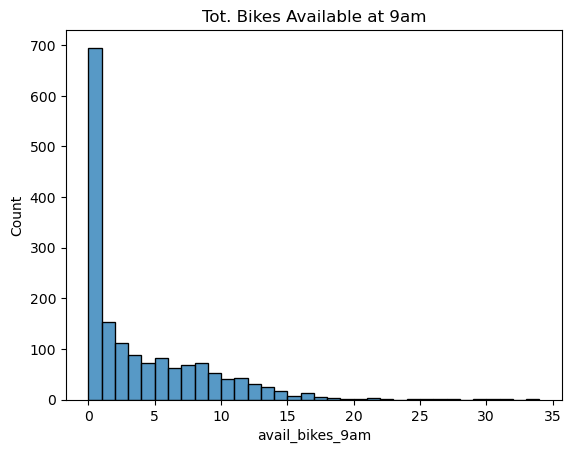

In [31]:
sns.histplot(df2['avail_bikes_9am']).set(title='Tot. Bikes Available at 9am')
plt.show()
#lots of empty bike stations.. this COULD be due to an error either in my code, or a defect in the city_bike API

In [32]:
len(df2.loc[df2['avail_bikes_9am']<1]) 
# the number of stations showing zero available bikes at 9 am is VERY high, nearly 1/3 of all stations, 
#this should be investigated

695

In [33]:
len(df2.loc[df2['change_8_to_9']<0]) 
# number of stations with fewer bikes than at 8am

181

In [34]:
len(df2.loc[df2['change_8_to_9']>0]) 
# number of stations with more bikes than at 8am

138

In [35]:
len(df2.loc[df2['change_8_to_9']==0]) 
# number of stations with no change from 8am to 9am

1344

In [36]:
#now let's run these while sorting by proximity to a station 
#(denoted by transit_cat value between 0 and 3, with 0 meaning it is near a CTA station and 3 meaning it isn't, with gradients in between )

In [37]:
print(len(df2.loc[df2['transit_cat']==0]))
print(len(df2.loc[df2['transit_cat']==1]))
print(len(df2.loc[df2['transit_cat']==2]))
print(len(df2.loc[df2['transit_cat']==3]))
#returns the size of our transit_cat groups
#examining the size of our transit categories, which will give some ideas about how likely we are to find results
#larger sizes should give us more hope

22
52
127
1462


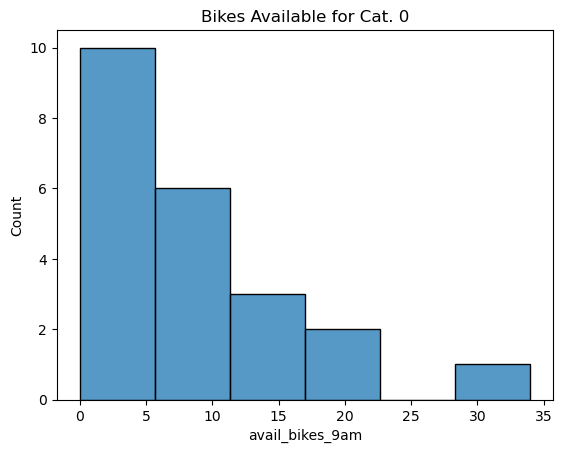

In [38]:
sns.histplot(df2.loc[df2['transit_cat']==0]['avail_bikes_9am']).set(title='Bikes Available for Cat. 0')
plt.show()

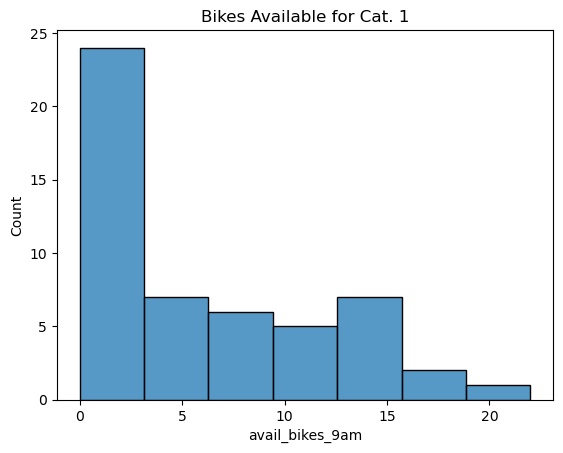

In [39]:
sns.histplot(df2.loc[df2['transit_cat']==1]['avail_bikes_9am']).set(title='Bikes Available for Cat. 1')
plt.show()

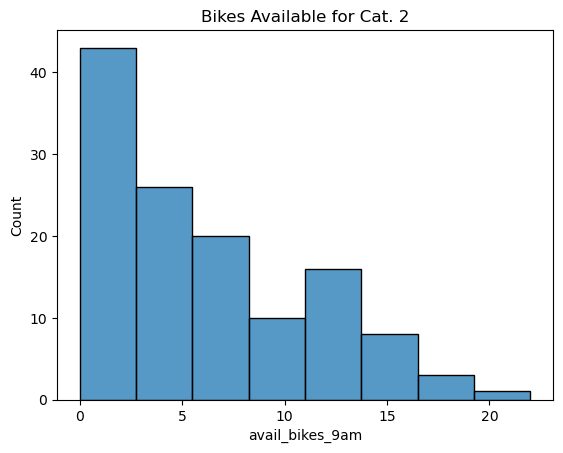

In [40]:
sns.histplot(df2.loc[df2['transit_cat']==2]['avail_bikes_9am']).set(title='Bikes Available for Cat. 2')
plt.show()

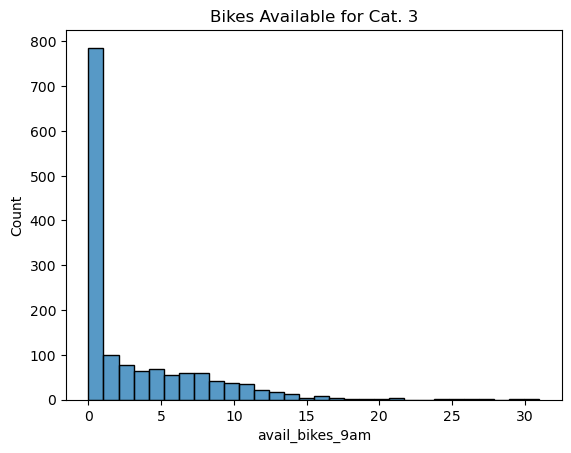

In [41]:
sns.histplot(df2.loc[df2['transit_cat']==3]['avail_bikes_9am']).set(title='Bikes Available for Cat. 3')
plt.show()

In [42]:
#at a glance we can see that the spike near the zero is MUCH large for stations with a greater distance to the nearest CTA station.
#this suggests some sort of relationship

In [43]:
#can we see a relationship between the change between 8am and 9am and proximity to CTA stations?

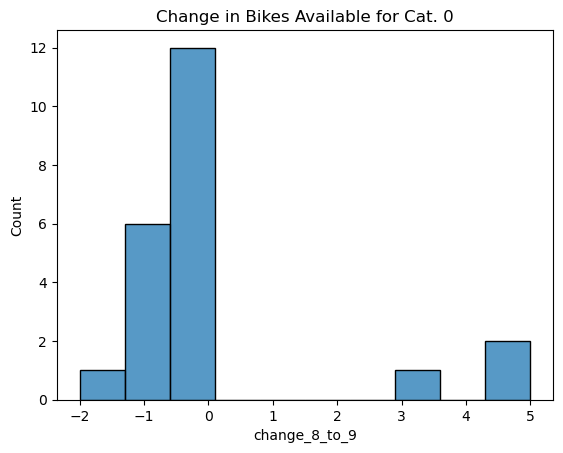

In [44]:
sns.histplot(df2.loc[df2['transit_cat']==0]['change_8_to_9']).set(title='Change in Bikes Available for Cat. 0')
plt.show()

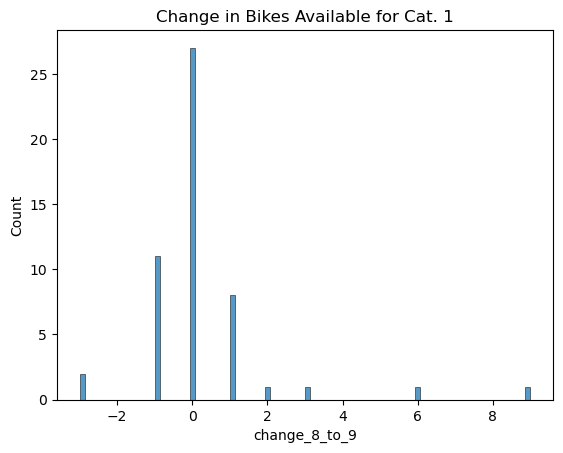

In [45]:
sns.histplot(df2.loc[df2['transit_cat']==1]['change_8_to_9']).set(title='Change in Bikes Available for Cat. 1')
plt.show()

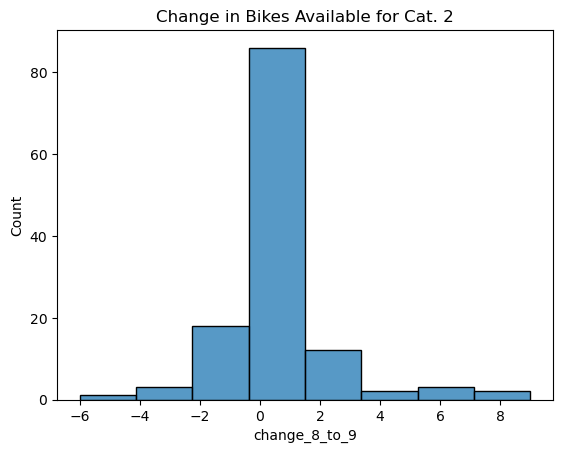

In [46]:
sns.histplot(df2.loc[df2['transit_cat']==2]['change_8_to_9']).set(title='Change in Bikes Available for Cat. 2')
plt.show()

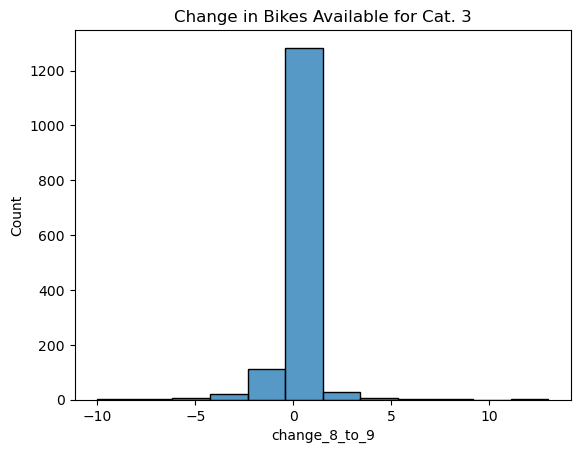

In [47]:
sns.histplot(df2.loc[df2['transit_cat']==3]['change_8_to_9']).set(title='Change in Bikes Available for Cat. 3')
plt.show()

In [48]:
#These graphs also show a clear difference in our transit_cats

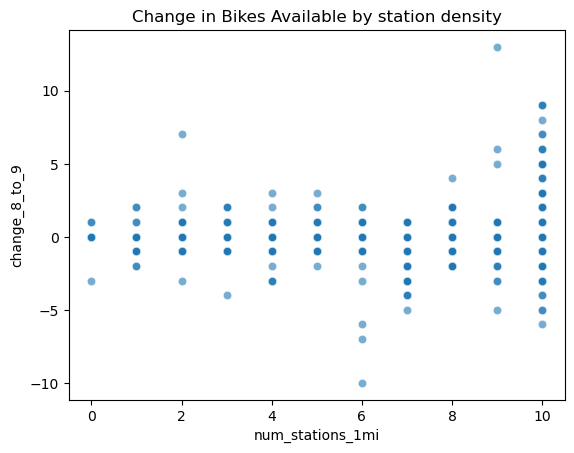

In [49]:
sns.scatterplot(x=df2['num_stations_1mi'], y=df2['change_8_to_9'], alpha=0.6).set(title='Change in Bikes Available by station density')
plt.show()

In [50]:
#these graphs show that the density of stations near a bike-station also may be determining the change in stations

<Axes: xlabel='distance', ylabel='avail_bikes_9am'>

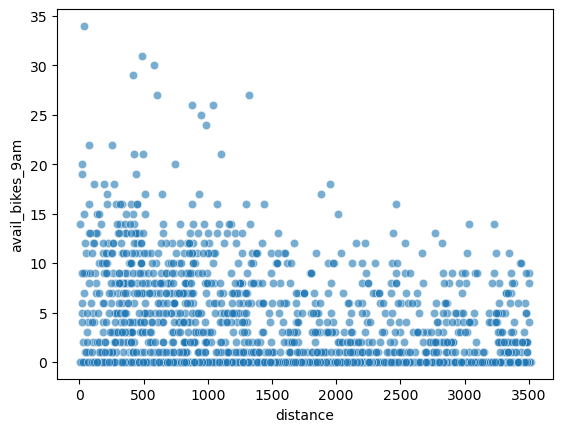

In [51]:
sns.scatterplot(x=df2['distance'], y=df2['avail_bikes_9am'], alpha=0.6) #no apparent correlation... but perhaps a statistical model will prove more useful

In [71]:
data1.columns

Index(['comp_id', 'name', 'latitude', 'longitude', 'slots', 'free_bikes',
       'renting', 'timestamp'],
      dtype='object')

##### as far as adding data to our SQL server, I would prefer at this point adding data closer to the raw source. 
##### since a great deal of the changes made here with python can also be easily made in SQL, this will retain greater flexabilty for future analystis

In [ ]:
#having already created the database 'Divvy_Rideshare' in postgres, we can now set up some basic tables

In [96]:
import psycopg2

con = psycopg2.connect(database="Divvy_Rideshare", user="postgres", password="Burning5", host="127.0.0.1", port="5432")

print("Database opened successfully")

Database opened successfully


In [84]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1663 entries, 0 to 1662
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   comp_id     1663 non-null   object        
 1   name        1663 non-null   object        
 2   latitude    1663 non-null   float64       
 3   longitude   1663 non-null   float64       
 4   slots       1663 non-null   int64         
 5   free_bikes  1663 non-null   int64         
 6   timestamp   1663 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 103.9+ KB


In [85]:
con = psycopg2.connect(database="Divvy_Rideshare", user="postgres", password="Burning5", host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute('''CREATE TABLE usage_data
      (comp_id     TEXT    NOT NULL,
      name    TEXT    NOT NULL,
      latitude    FLOAT    NOT NULL,
      longitude    FLOAT    NOT NULL,
      slots    INT    NOT NULL,
      free_bikes    INT    NOT NULL,
      timestamp    TIMESTAMP    NOT NULL);''')
print("Table created successfully")

con.commit()
con.close()

Table created successfully


In [112]:
con = psycopg2.connect(database="Divvy_Rideshare", user="postgres", password="Burning5", host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute('''CREATE TABLE cta_station_data
      (name    TEXT PRIMARY KEY    NOT NULL,
      distance    INT    NOT NULL,
      near_station    TEXT    NOT NULL,
      num_stations_1mi    INT    NOT NULL,
      num_stations_2mi    INT    NOT NULL,
      all_stations    INT    NOT NULL);''')
print("Table created successfully")
###NOTE name here is used as a primary key, since we should never expect duplicates of the information in this table, and this data will be matched to the results in usage_data on that name
#a better system should be found going forwards.
con.commit()
con.close()

DuplicateTable: relation "cta_station_data" already exists


In [98]:
con.close()

In [99]:
import psycopg2
param_dic = {
    "host"      : "127.0.0.1",
    "database"  : "Divvy_Rideshare",
    "user"      : "postgres",
    "password"  : "Burning5"
}

In [100]:
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn
conn = connect(param_dic)

Connecting to the PostgreSQL database...
Connection successful


In [105]:
def execute_values(conn, df, table):
    """
    Using psycopg2.extras.execute_values() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_values() done")

In [ ]:
del data2['renting'] #removes the unnecessary 'renting' column from the data

In [106]:
execute_values(conn, data1, 'usage_data')

execute_values() done


In [108]:
del data2['renting']

In [109]:
execute_values(conn, data2, 'usage_data')

execute_values() done


In [110]:
data3 = pd.read_json(r'unprocessed/Chi_9am_mon(raw).json')
del data3['renting']

In [111]:
execute_values(conn, data3, 'usage_data')

execute_values() done


In [114]:
df_fs['name'] = data3['name']

In [116]:
df_fs = df_fs[['name','distance','near_station','num_stations_1mi','num_stations_2mi','all_stations']]

In [117]:
df_fs.head()

,name,distance,near_station,num_stations_1mi,num_stations_2mi,all_stations
0,Lake Park Ave & 56th St,653,"5311 S Lake Park Ave (at 53rd St), Chicago, IL...",8,2,10
1,Ada St & Washington Blvd,384,"1200 W Randolph St, Chicago, IL 60607",9,1,10
2,Ashland Ave & Grace St,432,1612 W Irving Park Rd (btwn Ashland Ave. & Pau...,10,0,10
3,Clark St & Wrightwood Ave,500,"2548 N Halsted St (at Wrightwood Ave), Chicago...",10,0,10
4,Adler Planetarium,1421,"1416 S Michigan Ave, Chicago, IL 60605",5,5,10


In [118]:
execute_values(conn, df_fs, 'cta_station_data')

execute_values() done
